# MLB: Impact Games vs. Playoff Performance

There are 162 games for each team in the regular season. Each team plays the same number of games, but there are no two schedules exactly alike. I have a theory that you can tell how good a team is by seeing how well they perform against the best. For this project, I wanted to isolate how well a team performs in what I call 'impact games' vs how well they perform in the post season. I define impact games as: 

- a regular season game where both teams end up making the playoffs in that same season and at least one starting pitcher makes a postseason start in that year.
- Impact game for team A if: starting pitcher for Team B makes at least one start in the playoffs in that same season.
- Impact game for team B if: starting pitcher for Team A makes at least one start in the playoffs in that same season.
- Impact game for both A and B if: both starting pitchers make at least one start in the playoffs in that same season.

I will see if there is any correlation between winning percentage in impact games and winning percentage in the playoffs for the 2000-2018 season.



_The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at www.retrosheet.org_

## Libraries

In [192]:
import zipfile
import requests
import io
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
% matplotlib inline

## Gathering Data

In [2]:
# Webscrape game log data from retrosheet.org

game_logs = ['2000_09', '2010_18', 'wc', 'dv', 'lc', 'ws']
for dataset in game_log_list:
    url = 'https://www.retrosheet.org/gamelogs/gl{}.zip'.format(dataset)
    response = requests.get(url)
    zip_ref = zipfile.ZipFile(io.BytesIO(response.content))
    zip_ref.extractall()

## Cleaning Data

### Playoff Data

We can now access game logs for all playoffs games. For this project, we need to use the data to create a single data frame with the following columns: 
- team_id (in the format of year_team. This will distinguish the same team from year-to-year)
- wins
- losses
- win_perc
- year

In [120]:
# import game logs for all playoff series and combine into a single data frame

wildcard_games = pd.read_csv('glwc.txt', header=None)
division_series = pd.read_csv('gldv.txt', header=None)
championship_series = pd.read_csv('gllc.txt', header=None)
world_series = pd.read_csv('glws.txt', header=None)

playoff_gl = pd.concat([wildcard_games, division_series, championship_series, world_series])
playoff_gl.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,20121005,0,Fri,BAL,AL,1,TEX,AL,1,5,...,Mike Napoli,10,sotog001,Geovany Soto,2,gentc001,Craig Gentry,8,NaN,Y
1,20121005,0,Fri,SLN,NL,1,ATL,NL,1,6,...,David Ross,2,simma001,Andrelton Simmons,6,medlk001,Kris Medlen,1,NaN,Y
2,20131001,0,Tue,CIN,NL,1,PIT,NL,1,2,...,Russell Martin,2,barmc001,Clint Barmes,6,lirif001,Francisco Liriano,1,NaN,Y
3,20131002,0,Wed,TBA,AL,1,CLE,AL,1,4,...,Asdrubal Cabrera,6,gomey001,Yan Gomes,2,chisl001,Lonnie Chisenhall,5,NaN,Y
4,20140930,0,Tue,OAK,AL,1,KCA,AL,1,8,...,Salvador Perez,2,infao001,Omar Infante,4,mousm001,Mike Moustakas,5,NaN,Y


In [121]:
# Only relevant columns needed for this analysis 0, 3, 6, 9, 10, 101, 102, 103, 104. Reference Guide
# for dataframe details

playoff_gl_rel = playoff_gl[[0,3,6,9,10,101,102,103,104]]

In [122]:
# Rename columns

playoff_gl_rel = playoff_gl_rel.rename(columns = {0:'date', 3:'visiting_team', 6:'home_team', 
                                9:'visiting_team_score', 10:'home_team_score', 
                                101:'visiting_sp_id', 102:'visiting_sp', 
                                103:'home_sp_id', 104:'home_sp'})

In [123]:
# Change 'date' column to date format

playoff_gl_rel['date'] = pd.to_datetime(playoff_gl_rel['date'], format='%Y%m%d')

In [124]:
# Create columns for losing team and winning team of each game

playoff_gl_rel['winning_team'] = np.where(playoff_gl_rel['visiting_team_score'] > playoff_gl_rel['home_team_score'], 
                                          playoff_gl_rel['visiting_team'], playoff_gl_rel['home_team'])

playoff_gl_rel['losing_team'] = np.where(playoff_gl_rel['visiting_team_score'] > playoff_gl_rel['home_team_score'], 
                                         playoff_gl_rel['home_team'], playoff_gl_rel['visiting_team'])

In [125]:
# Create unique id's for winning and losing teams that combine year and team

playoff_gl_rel['winning_team_id'] = playoff_gl_rel['date'].dt.year.map(str) + " " + playoff_gl_rel['winning_team']
playoff_gl_rel['losing_team_id'] = playoff_gl_rel['date'].dt.year.map(str) + " " + playoff_gl_rel['losing_team']

# Create unique id's for pitchers starting playoff games that combine year, name, team
playoff_gl_rel['visiting_sp_id'] = playoff_gl_rel['date'].dt.year.map(str) + " " + playoff_gl_rel['visiting_sp'] + " " + playoff_gl_rel['visiting_team']
playoff_gl_rel['home_sp_id'] = playoff_gl_rel['date'].dt.year.map(str) + " " + playoff_gl_rel['home_sp'] + " " + playoff_gl_rel['home_team']

playoff_gl_rel.head()

,date,visiting_team,home_team,visiting_team_score,home_team_score,visiting_sp_id,visiting_sp,home_sp_id,home_sp,winning_team,losing_team,winning_team_id,losing_team_id
0,2012-10-05,BAL,TEX,5,1,2012 Joe Saunders BAL,Joe Saunders,2012 Yu Darvish TEX,Yu Darvish,BAL,TEX,2012 BAL,2012 TEX
1,2012-10-05,SLN,ATL,6,3,2012 Kyle Lohse SLN,Kyle Lohse,2012 Kris Medlen ATL,Kris Medlen,SLN,ATL,2012 SLN,2012 ATL
2,2013-10-01,CIN,PIT,2,6,2013 Johnny Cueto CIN,Johnny Cueto,2013 Francisco Liriano PIT,Francisco Liriano,PIT,CIN,2013 PIT,2013 CIN
3,2013-10-02,TBA,CLE,4,0,2013 Alex Cobb TBA,Alex Cobb,2013 Danny Salazar CLE,Danny Salazar,TBA,CLE,2013 TBA,2013 CLE
4,2014-09-30,OAK,KCA,8,9,2014 Jon Lester OAK,Jon Lester,2014 James Shields KCA,James Shields,KCA,OAK,2014 KCA,2014 OAK


In [135]:
playoff_gl_rel.to_csv('playoff_gamelogs.csv')

In [55]:
# Create a data frame for playoff wins by team and playoff losses by team

playoff_wins = pd.DataFrame(playoff_gl_rel['winning_team_id'].value_counts().reset_index())
playoff_losses = pd.DataFrame(playoff_gl_rel['losing_team_id'].value_counts().reset_index())

# Merge the two dataframes on index(team id)
playoff_records = pd.merge(playoff_wins, playoff_losses, on='index', how='outer')
playoff_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 3 columns):
index              440 non-null object
winning_team_id    368 non-null float64
losing_team_id     428 non-null float64
dtypes: float64(2), object(1)
memory usage: 13.8+ KB


In [58]:
# Non-null values are due to a team not losing or not winning a game during that years playoffs
# Fill na's with '0'

playoff_records.fillna(0, inplace=True)

# Rename columns: team_id, wins, losses
playoff_records = playoff_records.rename(columns={'index':'team_id', 'winning_team_id':'wins', 'losing_team_id':'losses'})

# Change wins and losses to integers
playoff_records['wins'] = playoff_records['wins'].astype(int)
playoff_records['losses'] = playoff_records['losses'].astype(int)

playoff_records.head()

,team_id,wins,losses
0,2014 SFN,12,5
1,1999 NYA,11,1
2,2008 PHI,11,3
3,2013 BOS,11,5
4,1998 NYA,11,2


In [59]:
playoff_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 3 columns):
team_id    440 non-null object
wins       440 non-null int32
losses     440 non-null int32
dtypes: int32(2), object(1)
memory usage: 10.3+ KB


In [77]:
# Add a winning percentage column

playoff_records['win_perc'] = playoff_records['wins']/(playoff_records['wins'] + playoff_records['losses'])

# Add a year column

playoff_records['year'] = playoff_records['team_id'].str[:4].astype(int)

In [206]:
playoff_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 5 columns):
team_id     440 non-null object
wins        440 non-null int32
losses      440 non-null int32
win_perc    440 non-null float64
year        440 non-null int32
dtypes: float64(1), int32(3), object(1)
memory usage: 15.5+ KB


In [208]:
# Create a data frame for playoff games from 2000-2018

playoff_records_2000 = playoff_records[playoff_records['year'] >= 2000]
playoff_records_2000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 439
Data columns (total 5 columns):
team_id     166 non-null object
wins        166 non-null int32
losses      166 non-null int32
win_perc    166 non-null float64
year        166 non-null int32
dtypes: float64(1), int32(3), object(1)
memory usage: 5.8+ KB


In [209]:
# save data frames to a .csv file

playoff_records.to_csv('playoff_records.csv')
playoff_records_2000.to_csv('playoff_records_2000_2018.csv')

### Regular Season Data

In [215]:
# import game logs for regular season starting in the year 2000

years = list(range(2000,2019))
reg_season_gl = pd.DataFrame()

for year in years:
    gl_df = pd.read_csv('gl{}.txt'.format(year), header=None)
    reg_season_gl = pd.concat([reg_season_gl, gl_df])
    
reg_season_gl.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,...,Todd Zeile,3,ordor001,Rey Ordonez,6,hampm001,Mike Hampton,1,NaN,Y
1,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,...,Jeff Huson,6,giraj001,Joe Girardi,2,farnk001,Kyle Farnsworth,1,NaN,Y
2,20000403,0,Mon,COL,NL,1,ATL,NL,1,0,...,Eddie Perez,2,weisw001,Walt Weiss,6,maddg002,Greg Maddux,1,NaN,Y
3,20000403,0,Mon,MIL,NL,1,CIN,NL,1,3,...,Aaron Boone,5,tuckm001,Michael Tucker,7,harnp001,Pete Harnisch,1,NaN,Y
4,20000403,0,Mon,SFN,NL,1,FLO,NL,1,4,...,Brant Brown,9,redmm001,Mike Redmond,2,ferna001,Alex Fernandez,1,NaN,Y


In [216]:
# Only relevant columns needed for this analysis 0, 3, 6, 9, 10, 101, 102, 103, 104. Reference Guide
# for dataframe details

reg_season_gl_rel = reg_season_gl[[0,3,6,9,10,101,102,103,104]]

In [217]:
# Rename columns

reg_season_gl_rel = reg_season_gl_rel.rename(columns = {0:'date', 3:'visiting_team', 6:'home_team', 
                                9:'visiting_team_score', 10:'home_team_score', 
                                101:'visiting_sp_id', 102:'visiting_sp', 
                                103:'home_sp_id', 104:'home_sp'})

In [218]:
# Change 'date' column to date format

reg_season_gl_rel['date'] = pd.to_datetime(reg_season_gl_rel['date'], format='%Y%m%d')

In [219]:
# Create columns for losing team and winning team of each game

reg_season_gl_rel['winning_team'] = np.where(reg_season_gl_rel['visiting_team_score'] > reg_season_gl_rel['home_team_score'], 
                                          reg_season_gl_rel['visiting_team'], reg_season_gl_rel['home_team'])

reg_season_gl_rel['losing_team'] = np.where(reg_season_gl_rel['visiting_team_score'] > reg_season_gl_rel['home_team_score'], 
                                         reg_season_gl_rel['home_team'], reg_season_gl_rel['visiting_team'])

In [220]:
# Create unique id's for winning and losing teams that combine year and team

reg_season_gl_rel['winning_team_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['winning_team']
reg_season_gl_rel['losing_team_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['losing_team']

# Create unique id's for home team and away team using year and team

reg_season_gl_rel['home_team_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['home_team']
reg_season_gl_rel['visiting_team_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['visiting_team']

# Create unique id's for pitchers starting playoff games that combine year, name, team
reg_season_gl_rel['visiting_sp_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['visiting_sp'] + " " + reg_season_gl_rel['visiting_team']
reg_season_gl_rel['home_sp_id'] = reg_season_gl_rel['date'].dt.year.map(str) + " " + reg_season_gl_rel['home_sp'] + " " + reg_season_gl_rel['home_team']

reg_season_gl_rel.head()

,date,visiting_team,home_team,visiting_team_score,home_team_score,visiting_sp_id,visiting_sp,home_sp_id,home_sp,winning_team,losing_team,winning_team_id,losing_team_id,home_team_id,visiting_team_id
0,2000-03-29,CHN,NYN,5,3,2000 Jon Lieber CHN,Jon Lieber,2000 Mike Hampton NYN,Mike Hampton,CHN,NYN,2000 CHN,2000 NYN,2000 NYN,2000 CHN
1,2000-03-30,NYN,CHN,5,1,2000 Rick Reed NYN,Rick Reed,2000 Kyle Farnsworth CHN,Kyle Farnsworth,NYN,CHN,2000 NYN,2000 CHN,2000 CHN,2000 NYN
2,2000-04-03,COL,ATL,0,2,2000 Pedro Astacio COL,Pedro Astacio,2000 Greg Maddux ATL,Greg Maddux,ATL,COL,2000 ATL,2000 COL,2000 ATL,2000 COL
3,2000-04-03,MIL,CIN,3,3,2000 Steve Woodard MIL,Steve Woodard,2000 Pete Harnisch CIN,Pete Harnisch,CIN,MIL,2000 CIN,2000 MIL,2000 CIN,2000 MIL
4,2000-04-03,SFN,FLO,4,6,2000 Livan Hernandez SFN,Livan Hernandez,2000 Alex Fernandez FLO,Alex Fernandez,FLO,SFN,2000 FLO,2000 SFN,2000 FLO,2000 SFN


In [221]:
# save data to a .csv file

reg_season_gl_rel.to_csv('regular_season_gl.csv')

### The Final Data Frame

Using our *playoff_records* and *playoff_gl_rel* data frames, we can create a list of all playoff teams and all starting pitchers of playoff games from the year 2000-2018. We can use these lists to find all impact games. After this we can calculate a teams winning percentage in impact games. Then we have all the information needed to look into any correlation between impact records in impact games and in playoff games.

# Create an list of all playoff teams from 2000-2018

playoff_records_2000 = playoff_records[playoff_records['year'] >= 2000]
playoff_teams_list = playoff_records_2000['team_id'].values.ravel('K')
playoff_teams_list

In [134]:
# Create an array of all pitchers that started a playoff game from 2000-2018

playoff_gl_2000 = playoff_gl_rel[pd.DatetimeIndex(playoff_gl_rel['date']).year >= 2000]
playoff_pitcher_list = pd.unique(playoff_gl_2000[['home_sp_id','visiting_sp_id']].values.ravel('K'))
playoff_pitcher_list

array(['2012 Yu Darvish TEX', '2012 Kris Medlen ATL',
       '2013 Francisco Liriano PIT', '2013 Danny Salazar CLE',
       '2014 James Shields KCA', '2014 Edinson Volquez PIT',
       '2015 Masahiro Tanaka NYA', '2015 Gerrit Cole PIT',
       '2016 Marcus Stroman TOR', '2016 Noah Syndergaard NYN',
       '2017 Luis Severino NYA', '2017 Zack Greinke ARI',
       '2018 Jon Lester CHN', '2018 Luis Severino NYA',
       '2000 Rick Ankiel SLN', '2000 Gil Heredia OAK',
       '2000 Jim Parque CHA', '2000 Livan Hernandez SFN',
       '2000 Kevin Appier OAK', '2000 Mike Sirotka CHA',
       '2000 Darryl Kile SLN', '2000 Shawn Estes SFN',
       '2000 Orlando Hernandez NYA', '2000 Aaron Sele SEA',
       '2000 Kevin Millwood ATL', '2000 Rick Reed NYN',
       '2000 Roger Clemens NYA', '2000 Bobby Jones NYN',
       '2001 Freddy Garcia SEA', '2001 Wade Miller HOU',
       '2001 Curt Schilling ARI', '2001 Roger Clemens NYA',
       '2001 Dave Mlicki HOU', '2001 Randy Johnson ARI',
       '2001 J

Now we can iterate through our *reg_season_gl_rel* data frame to find all impact games. Impact games must meet the following criteria:

- a regular season game where both teams end up making the playoffs in that same season and at least one starting pitcher makes a postseason start in that year.
- Impact game for team A if: starting pitcher for Team B makes at least one start in the playoffs in that same season.
- Impact game for team B if: starting pitcher for Team A makes at least one start in the playoffs in that same season.
- Impact game for both A and B if: both starting pitchers make at least one start in the playoffs in that same season.

All impact games will be added to a new data frame.

In [222]:
pd.options.mode.chained_assignment = None
index_range = list(range(reg_season_gl_rel.shape[0]))
impact_games_df = pd.DataFrame()
impact_games_index = 0 

for index in index_range:
    if ((reg_season_gl_rel.iloc[index]['home_team_id'] in playoff_teams_list) and (reg_season_gl_rel.iloc[index]['visiting_sp_id'] in playoff_pitcher_list)): 
        temp_df = reg_season_gl_rel.iloc[index]
        temp_df['team'] = reg_season_gl_rel.iloc[index]['home_team_id']
        impact_games_df = impact_games_df.append(temp_df)            
    if ((reg_season_gl_rel.iloc[index]['visiting_team_id'] in playoff_teams_list) and (reg_season_gl_rel.iloc[index]['home_sp_id'] in playoff_pitcher_list)):
        temp_df = reg_season_gl_rel.iloc[index]
        temp_df['team'] = reg_season_gl_rel.iloc[index]['visiting_team_id']
        impact_games_df = impact_games_df.append(temp_df)
        

In [223]:
impact_games_df

,date,home_sp,home_sp_id,home_team,home_team_id,home_team_score,losing_team,losing_team_id,team,visiting_sp,visiting_sp_id,visiting_team,visiting_team_id,visiting_team_score,winning_team,winning_team_id
54,2000-04-07,Terry Mulholland,2000 Terry Mulholland ATL,ATL,2000 ATL,2.0,ATL,2000 ATL,2000 ATL,Mark Gardner,2000 Mark Gardner SFN,SFN,2000 SFN,6.0,SFN,2000 SFN
64,2000-04-07,Gil Heredia,2000 Gil Heredia OAK,OAK,2000 OAK,6.0,OAK,2000 OAK,2000 CHA,Cal Eldred,2000 Cal Eldred CHA,CHA,2000 CHA,7.0,CHA,2000 CHA
65,2000-04-07,John Halama,2000 John Halama SEA,SEA,2000 SEA,7.0,NYA,2000 NYA,2000 SEA,Andy Pettitte,2000 Andy Pettitte NYA,NYA,2000 NYA,5.0,SEA,2000 SEA
65,2000-04-07,John Halama,2000 John Halama SEA,SEA,2000 SEA,7.0,NYA,2000 NYA,2000 NYA,Andy Pettitte,2000 Andy Pettitte NYA,NYA,2000 NYA,5.0,SEA,2000 SEA
69,2000-04-08,Greg Maddux,2000 Greg Maddux ATL,ATL,2000 ATL,7.0,SFN,2000 SFN,2000 ATL,Livan Hernandez,2000 Livan Hernandez SFN,SFN,2000 SFN,5.0,ATL,2000 ATL
69,2000-04-08,Greg Maddux,2000 Greg Maddux ATL,ATL,2000 ATL,7.0,SFN,2000 SFN,2000 SFN,Livan Hernandez,2000 Livan Hernandez SFN,SFN,2000 SFN,5.0,ATL,2000 ATL
79,2000-04-08,Ron Mahay,2000 Ron Mahay OAK,OAK,2000 OAK,3.0,OAK,2000 OAK,2000 OAK,Mike Sirotka,2000 Mike Sirotka CHA,CHA,2000 CHA,7.0,CHA,2000 CHA
80,2000-04-08,Gil Meche,2000 Gil Meche SEA,SEA,2000 SEA,2.0,SEA,2000 SEA,2000 SEA,Orlando Hernandez,2000 Orlando Hernandez NYA,NYA,2000 NYA,3.0,NYA,2000 NYA
84,2000-04-09,Tom Glavine,2000 Tom Glavine ATL,ATL,2000 ATL,9.0,SFN,2000 SFN,2000 ATL,Russ Ortiz,2000 Russ Ortiz SFN,SFN,2000 SFN,3.0,ATL,2000 ATL
84,2000-04-09,Tom Glavine,2000 Tom Glavine ATL,ATL,2000 ATL,9.0,SFN,2000 SFN,2000 SFN,Russ Ortiz,2000 Russ Ortiz SFN,SFN,2000 SFN,3.0,ATL,2000 ATL


In [224]:
impact_games_df.shape

(3653, 16)

In [225]:
impact_games_df.duplicated().sum()

0

In [226]:
# Create a column that shows if team won or lost impact game(1=win, 0=loss)

impact_games_df['impact_game_outcome'] = np.where(impact_games_df['team'] == impact_games_df['winning_team_id'], 1, 0)

In [229]:
# Create a new data frame showing team_id and total impact games

total_impact_games = pd.DataFrame(impact_games_df.groupby(['team'])['impact_game_outcome'].count().reset_index())
total_impact_games = total_impact_games.rename(columns = {'impact_game_outcome':'total_games'})
total_impact_games.head()

,team,total_games
0,2000 ATL,25
1,2000 CHA,27
2,2000 NYA,25
3,2000 NYN,29
4,2000 OAK,23


In [230]:
# Create a new data frame showing team id and total impact game wins

impact_wins = pd.DataFrame(impact_games_df.groupby(['team'])['impact_game_outcome'].sum().reset_index())
impact_wins = impact_wins.rename(columns = {'impact_game_outcome':'wins'})
impact_wins.head()

,team,wins
0,2000 ATL,11
1,2000 CHA,16
2,2000 NYA,10
3,2000 NYN,17
4,2000 OAK,10


In [231]:
# Merge these 2 data frames into one data frame that will have team_ids and impact game records

impact_games_record = pd.merge(total_impact_games, impact_wins, on='team', how='outer')
impact_games_record = impact_games_record.rename(columns = {'team':'team_id'})
impact_games_record['impact_games_win_perc'] = impact_games_record['wins'] / impact_games_record['total_games']
impact_games_record.head()

,team_id,total_games,wins,impact_games_win_perc
0,2000 ATL,25,11,0.440000
1,2000 CHA,27,16,0.592593
2,2000 NYA,25,10,0.400000
3,2000 NYN,29,17,0.586207
4,2000 OAK,23,10,0.434783


Now we have a data frame showing winning percentage for impact games and winning percentage in playoff games. We can combine these 2 data frames on team_id to create a final data frame used for analysis.

In [232]:
team_results = pd.merge(impact_games_record, playoff_records_2000, on='team_id', how='outer')
team_results = team_results.rename(columns={'win_perc':'playoff_win_perc'})

team_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 8 columns):
team_id                  166 non-null object
total_games              166 non-null int64
wins_x                   166 non-null int32
impact_games_win_perc    166 non-null float64
wins_y                   166 non-null int32
losses                   166 non-null int32
playoff_win_perc         166 non-null float64
year                     166 non-null int32
dtypes: float64(2), int32(4), int64(1), object(1)
memory usage: 9.1+ KB


## Analysis

Using our *team_reults* data frame, we can look into any correlation between performance in impact games and performance in playoff games.

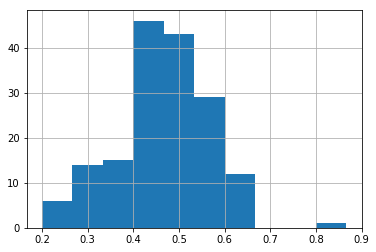

In [233]:
team_results['impact_games_win_perc'].hist();

In [234]:
team_results['impact_games_win_perc'].describe()

count    166.000000
mean       0.465167
std        0.104767
min        0.200000
25%        0.401852
50%        0.470588
75%        0.535119
max        0.866667
Name: impact_games_win_perc, dtype: float64

In [235]:
team_results[team_results['impact_games_win_perc'] > .8]

,team_id,total_games,wins_x,impact_games_win_perc,wins_y,losses,playoff_win_perc,year
89,2011 DET,15,13,0.866667,5,6,0.454545,2011


We can see the distribution and descriptive statistics of winning percentage in impact games. There is one outlier which is the 2011 Detroit Tigers. They played in 15 impact games and won 13 of those. However, they only won 5 playoff games. This means that they lost in the AL Championship Series.

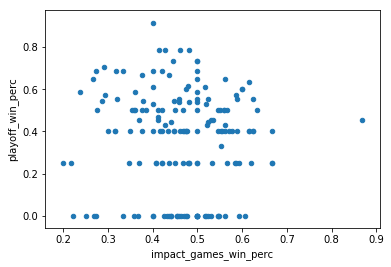

In [236]:
team_results.plot(x='impact_games_win_perc', y='playoff_win_perc', kind='scatter')

In [238]:
team_results['intercept'] = 1

lm = sm.OLS(team_results['impact_games_win_perc'], team_results[['intercept', 'playoff_win_perc']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     impact_games_win_perc   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.005
Method:                    Least Squares   F-statistic:                    0.1978
Date:                   Tue, 05 Feb 2019   Prob (F-statistic):              0.657
Time:                           12:50:40   Log-Likelihood:                 139.56
No. Observations:                    166   AIC:                            -275.1
Df Residuals:                        164   BIC:                            -268.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.4708      0.015     31.376      0.000       0.441       0.500
playoff_win_perc    -0.0153      0.034     -0.445      0.657      -0.083       0.052
==============================================================================
Omnibus:                        3.037   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                3.301
Skew:                          -0.019   Prob(JB):                        0.192
Kurtosis:                       3.690   Cond. No.                         4.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By looking at the scatter plot, there is no evident correlation to winning percentage in impact games vs winnning percentage in the playoffs. The linear model confirms the minimal corrlation observed in the scatter plot. The linear model shows a low R-squared value and a high p-value.

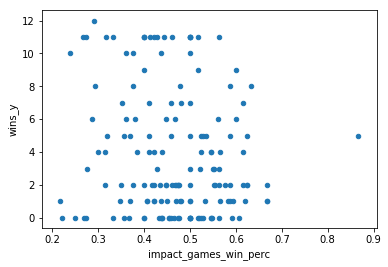

In [191]:
team_results.plot(x='impact_games_win_perc', y='wins_y', kind='scatter')

In [239]:
team_results['intercept'] = 1

lm = sm.OLS(team_results['impact_games_win_perc'], team_results[['intercept', 'wins_y']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     impact_games_win_perc   R-squared:                       0.016
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     2.588
Date:                   Tue, 05 Feb 2019   Prob (F-statistic):              0.110
Time:                           12:55:26   Log-Likelihood:                 140.76
No. Observations:                    166   AIC:                            -277.5
Df Residuals:                        164   BIC:                            -271.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4785      0.012     41.308      0.000       0.456       0.501
wins_y        -0.0035      0.002     -1.609      0.110      -0.008       0.001
==============================================================================
Omnibus:                        3.775   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                4.587
Skew:                          -0.020   Prob(JB):                        0.101
Kurtosis:                       3.813   Cond. No.                         7.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we change our y-axis variables to number of playoff wins, we have a slightly better model. But there is still very little correlation between impact game performance and postseason performance.